In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.context("plotly_white")
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import pickle
from datetime import datetime, timedelta
from scipy.signal import find_peaks
from statsmodels.stats.multitest import multipletests

import statsmodels.api as sm
from sklearn.metrics import r2_score
import warnings
import gc
from copy import deepcopy

In [2]:
us_df = pd.read_csv("data/us_data.csv")
all_states = pd.unique(us_df['state'])
all_states = all_states[(all_states != 'District of Columbia')]
us_df = us_df[us_df['state'].isin(all_states)]
us_df['date'] = pd.to_datetime(us_df['date'])

us_state_abbrev = pickle.load(open("data/us_state_abbrev.pkl", "rb"))
us_df['region'] = us_df['state'].map(us_state_abbrev)
us_df = us_df.drop(columns=['state'])

In [3]:
country_df = pd.read_csv("data/global_data.csv")
country_df['date'] = pd.to_datetime(country_df['date'])

country_abbrev = pickle.load(open("data/country_abbrev.pkl", "rb"))
country_df['region'] = country_df['country'].map(country_abbrev)
country_df = country_df.drop(columns=['country'])

In [4]:
df = pd.concat([us_df, country_df])
all_regions = pd.unique(df['region'])

In [5]:
def learn_betas(curr_region, start_time, end_time, R0=2.5, df=df):
    with warnings.catch_warnings():
        curr_df = df[df['region'] == curr_region]
        curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
        case_df = curr_df.set_index('date').resample('W-Mon').sum()
        case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
        case_df = case_df.iloc[:-2]
        
        new_df = pd.DataFrame(index=case_df.index)
        new_df['X2(t)'] = np.log(case_df['weekly_cases'] + 1)
        new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1).shift(1).fillna(0)
        new_df['X3(t)'] = new_df['X2(t)'] - new_df['X1(t)'] - np.log(R0)
        new_df['X3(t-1)'] = new_df['X3(t)'].shift(1).fillna(0)


        ## Assume that degree pruning is a function of previous cases and previous degree pruning
        X = new_df[['X1(t)', 'X3(t-1)']]
        X = sm.add_constant(X)
        X_train = X.iloc[start_time:end_time]

        ## Degree pruning parameter is equal to difference in cumulative values
        y = new_df['X3(t)'] - new_df['X3(t-1)']
        y_train = y.iloc[start_time:end_time]

        ## learn beta1 and beta2
        model = sm.OLS(y_train,X_train)
        results = model.fit()
        
        beta1 = results.params['X1(t)']
        beta2 = results.params['X3(t-1)']
        constant = results.params['const']
        return beta1, beta2, constant, results

In [6]:
def predict(curr_region, beta1, beta2, const, R0=2.5, df=df):
    curr_df = df[df['region'] == curr_region]
    curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
    case_df = curr_df.set_index('date').resample('W-Mon').sum()
    case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
    case_df = case_df.iloc[:-2]
    
    new_df = pd.DataFrame(index=case_df.index)
    new_df['X2(t)'] = np.log(case_df['weekly_cases'] + 1)
    new_df['X1(t)'] = np.log(case_df['weekly_cases'] + 1).shift(1).fillna(0)
    new_df['X3(t)'] = new_df['X2(t)'] - new_df['X1(t)'] - np.log(R0)
    new_df['X3(t-1)'] = new_df['X3(t)'].shift(1).fillna(0)
    
    full_preds = beta1*new_df['X1(t)'] + beta2*new_df['X3(t-1)'] + const + \
                + new_df['X1(t)'] + new_df['X3(t-1)'] + np.log(R0)
    return np.exp(full_preds) - 1, np.exp(new_df['X1(t)']) - 1

In [7]:
def compute_separation(curr_region, r = 4):
    with warnings.catch_warnings():
        curr_df = df[df['region'] == curr_region]
        curr_df = curr_df[['date', 'daily_cases', 'daily_deaths']]
        case_df = curr_df.set_index('date').resample('W-Mon').sum()
        case_df = case_df.rename(columns={"daily_cases": "weekly_cases", "daily_deaths": 'weekly_deaths'})
        case_df = case_df.iloc[:-2]
     # compute gamma  
    gamma_ts = np.log(case_df['weekly_cases']+1).diff().diff()
    peaks = find_peaks(gamma_ts, distance=15)[0]
    peaks = np.sort(peaks)
    
    first_trough = (0, 10)
    second_trough = (15, 20)
    third_trough = (30, 35)
    fourth_trough = (56, 62)
    fifth_trough = (72, 76)
    sixth_trough = (94, 98)
    
    r_sep_locs = [0,0,0,0,0, 0]
    trough_boundaries = [first_trough, second_trough, third_trough, fourth_trough, fifth_trough, sixth_trough]
    for i, trough in enumerate(trough_boundaries):
        r_sep_locs[i] = np.argmax(np.multiply(gamma_ts.fillna(0).to_numpy(), 
                                              np.multiply(
                                                  np.arange(len(gamma_ts)) >= trough[0],
                                                  np.arange(len(gamma_ts)) <= trough[1])
                                             ))
    return r_sep_locs

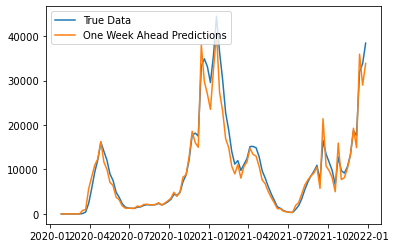

In [8]:
## test out
beta1, beta2, constant, results = learn_betas("MA", 0, 26)
full_preds, actual = predict("MA", beta1, beta2, constant)
plt.plot(actual, label='True Data')
plt.plot(full_preds, label='One Week Ahead Predictions')
plt.legend()

In [9]:
learned_betas = []
all_mult_strat_preds ={}
for curr_region in all_regions:
    try:
        mult_strat_preds = pd.Series(index=full_preds.index, dtype=float).fillna(0)   
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            r_sep_locs = compute_separation(curr_region)

            ## Individual Peaks
            for i in range(len(r_sep_locs)):
                if(i < len(r_sep_locs) - 1):
                    start_time, end_time = r_sep_locs[i], r_sep_locs[i + 1]
                elif(i == len(r_sep_locs) - 1):
                    start_time, end_time = r_sep_locs[i], None

                beta1, beta2, const, results = learn_betas(curr_region, start_time, end_time)
                full_preds, actual = predict(curr_region, beta1, beta2, const)

                if(i < len(r_sep_locs)):
                    mult_strat_preds.iloc[start_time:end_time] = full_preds.iloc[start_time:end_time] 

                ## compute r2 scores
                r2_in = r2_score(full_preds.iloc[start_time:end_time], actual.iloc[start_time:end_time])
                r2_pre = r2_score(full_preds.iloc[:start_time], actual.iloc[:start_time])
                if(end_time is not None):
                    r2_post = r2_score(full_preds.iloc[end_time:], actual.iloc[end_time:])
                else:
                    r2_post = np.nan
                learned_betas.append({
                    'region': curr_region,
                    'peak_no': str(i + 1),
                    'start_time': start_time,
                    'end_time': end_time,
                    'beta1': beta1,
                    'beta2':beta2,
                    'const': const,
                    'r2_in': r2_in,
                    'r2_pre': r2_pre,
                    'r2_post': r2_post
                })
            all_mult_strat_preds[curr_region] = mult_strat_preds

            ## Pairs of peaks
            for i in range(len(r_sep_locs)-1):
                if(i < len(r_sep_locs) - 2):
                    start_time, end_time = r_sep_locs[i], r_sep_locs[i + 2]
                elif(i == len(r_sep_locs) - 2):
                    start_time, end_time = r_sep_locs[i], None

                beta1, beta2, const, results = learn_betas(curr_region, start_time, end_time)
                full_preds, actual = predict(curr_region, beta1, beta2, const)

                ## compute r2 scores
                r2_in = r2_score(full_preds.iloc[start_time:end_time], actual.iloc[start_time:end_time])
                r2_pre = r2_score(full_preds.iloc[:start_time], actual.iloc[:start_time])
                if(end_time is not None):
                    r2_post = r2_score(full_preds.iloc[end_time:], actual.iloc[end_time:])
                else:
                    r2_post = np.nan
                learned_betas.append({
                    'region': curr_region,
                    'peak_no': f'{i+1}+{i+2}',
                    'start_time': start_time,
                    'end_time': end_time,
                    'beta1': beta1,
                    'beta2':beta2,
                    'const': const,
                    'r2_in': r2_in,
                    'r2_pre': r2_pre,
                    'r2_post': r2_post
                })

            # Full Data
            start_time = r_sep_locs[0]
            end_time = None
            beta1, beta2, const, results = learn_betas(curr_region, start_time, end_time)
            full_preds, actual = predict(curr_region, beta1, beta2, const)

            ## compute r2 scores
            r2_in = r2_score(full_preds.iloc[start_time:end_time], actual.iloc[start_time:end_time])
            r2_pre = np.nan #r2_score(full_preds.iloc[:start_time], actual.iloc[:start_time])
            if(end_time is not None):
                r2_post = r2_score(full_preds.iloc[end_time:], actual.iloc[end_time:])
            else:
                r2_post = np.nan
            learned_betas.append({
                'region': curr_region,
                'peak_no': '1+2+3+4+5+6',
                'start_time': start_time,
                'end_time': end_time,
                'beta1': beta1,
                'beta2':beta2,
                'const': const,
                'r2_in': r2_in,
                'r2_pre': r2_pre,
                'r2_post': r2_post
            })

            #  0-26
            start_time = 0
            end_time = 26
            beta1, beta2, const, results = learn_betas(curr_region, start_time, end_time)
            full_preds, actual = predict(curr_region, beta1, beta2, const)

            ## compute r2 scores
            r2_in = r2_score(full_preds.iloc[start_time:end_time], actual.iloc[start_time:end_time])
            r2_pre = np.nan #r2_score(full_preds.iloc[:start_time], actual.iloc[:start_time])
            if(end_time is not None):
                r2_post = r2_score(full_preds.iloc[end_time:], actual.iloc[end_time:])
            else:
                r2_post = np.nan
            learned_betas.append({
                'region': curr_region,
                'peak_no': '0to26',
                'start_time': start_time,
                'end_time': end_time,
                'beta1': beta1,
                'beta2':beta2,
                'const': const,
                'r2_in': r2_in,
                'r2_pre': r2_pre,
                'r2_post': r2_post
            })
    except Exception as e:
        pass
#         print(curr_region)
#         print(e)

In [10]:
out_sample_df = pd.DataFrame(learned_betas)

## Comparison to Auxiliary Data

In [11]:
# Google
google_df = pd.read_csv("data/Combined_Google_Mobility.csv")
google_df['date'] = pd.to_datetime(google_df['date'])


print([i for i in google_df.columns if i.endswith("from_baseline")])

google_df = google_df[['region', 'date'] + \
                      [i for i in google_df.columns if i.endswith("from_baseline")]].dropna()

from sklearn.decomposition import PCA
g_bs = google_df[[i for i in google_df.columns if i.endswith("from_baseline")]]

pca = PCA(n_components=2)
pca.fit(g_bs)
print(pca.explained_variance_ratio_)

transformed = pca.fit_transform(g_bs)
for i in range(2):
    google_df[f'pc{i+1}_google'] = transformed[:, i]
    
google_df = google_df[['region', 'date']  + [i for i in google_df.columns if i.startswith("pc")]].dropna()
google_df = google_df.dropna()

/state/partition1/llgrid/pkg/anaconda/anaconda3-2021a/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,4,5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


['retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']
[0.66922105 0.24463768]


In [12]:
# ## Cumulative cases
cum_case_df = df.groupby(["region"]).apply(lambda x: x[['date', 'daily_cases', 'daily_deaths']].set_index("date").resample('W-Mon').sum().cumsum())
cum_case_df = cum_case_df.reset_index().rename(columns=
                                               {'daily_cases': 'cumulative_cases', 
                                                'daily_deaths': 'cumulative_deaths'})

pops = pd.read_excel("data/populations.xlsx", index_col=0)
pops = pops[[2019]].reset_index().dropna()
pops.columns = ['state', 'population']
pops['state'] = pops['state'].str.replace(".","")
pops['region'] = pops['state'].map(us_state_abbrev)
pops = pops[['region', 'population']].dropna()

gpops = pd.read_csv("data/population_by_country_2020.csv")
gpops['region'] = gpops['Country (or dependency)'].map(country_abbrev)
gpops = gpops[['region', 'Population (2020)']].dropna()
gpops.columns = ['region', 'population']

pops = pd.concat([pops, gpops])
case_pop_df = pd.merge(cum_case_df, pops, on='region', how='left').dropna()
case_pop_df['cumulative_cases_normalized'] = case_pop_df['cumulative_cases'] / case_pop_df['population']
case_pop_df.head()
case_pop_df = case_pop_df.dropna()

## Coefficient Comparison

In [13]:
all_peak_nos = pd.unique(out_sample_df['peak_no'])

coef_p_arr = []

google_col_pairs = [("Google", google_df, i) for i in google_df.columns if i.startswith("pc")]
case_col_pairs = [("Cases", case_pop_df, i) for i in case_pop_df.columns if i.startswith("cumulative_cases_")]


def peak_to_cols(peak_no):
    return google_col_pairs + case_col_pairs

def time_from_idx(idx):
    if(pd.isnull(idx)):
        return datetime.strptime("2022-01-01", "%Y-%m-%d")
    else:
        return datetime.strptime("2020-01-27", "%Y-%m-%d") + timedelta(weeks=(idx))
        
all_peak_nos = ['0to26']
for peak_no in all_peak_nos:
    curr_df = deepcopy(out_sample_df[out_sample_df['peak_no'] == peak_no].reset_index(drop=True))
    curr_df = curr_df[[i for i in curr_df.columns if not i.startswith("r2")]]
    df_col_pairs = peak_to_cols(peak_no)
    print(peak_no, [x[2] for x in df_col_pairs])
    for (lbl, aux_df, x_col) in df_col_pairs:
        if(lbl == "Google"):
            curr_df[x_col] = 0
            for i, row in curr_df.iterrows():
                end_time = row['end_time'] if (row['end_time'] is not np.nan) else 1000
                small_aux_df = aux_df[(aux_df['region'] == row['region']) &
                                      (aux_df['date'] <= time_from_idx(end_time) - timedelta(days=1)) &
                                      (aux_df['date'] >= time_from_idx(row['start_time']))]
                curr_df.iloc[i, curr_df.columns.get_loc(x_col)] = small_aux_df[x_col].mean()
            X = deepcopy(curr_df[[x_col]])
            X = sm.add_constant(X)
        elif((lbl == "Cases")):
            curr_df[x_col] = 0
            for i, row in curr_df.iterrows():
                small_aux_df = aux_df[(aux_df['region'] == row['region']) &
                                      (aux_df['date'] <= time_from_idx(end_time) - timedelta(days=1)) &
                                      (aux_df['date'] >= time_from_idx(row['start_time']))]
                curr_df.iloc[i, curr_df.columns.get_loc(x_col)] = small_aux_df[x_col].max()
            X = deepcopy(curr_df[[x_col]])
            X = sm.add_constant(X)
        
        good_rows = ~np.any(X.isnull(), axis=1)
        for y_col in ['beta1', 'beta2']:
            y = curr_df[y_col][good_rows]
            X = X[good_rows]

            model = sm.OLS(y, X)
            results = model.fit()
            coef_p_arr.append({
                'dep': y_col,
                'ind': x_col,
                'peak_no': peak_no,
                'coef': results.params[x_col],
                'offset': results.params['const'],
                'pval_coef': results.pvalues[x_col],
#                 'pval_offset': results.pvalues['const'],
#                 'r2': results.rsquared,
#                 'r2_adj': results.rsquared_adj
            })

0to26 ['pc1_google', 'pc2_google', 'cumulative_cases_normalized']


<ipython-input-13-d645ac73c1cd>:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[good_rows]
<ipython-input-13-d645ac73c1cd>:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[good_rows]
<ipython-input-13-d645ac73c1cd>:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X = X[good_rows]


In [14]:
pvalue_df = pd.DataFrame(coef_p_arr)
sorted_df = pvalue_df.sort_values(by='pval_coef')

alpha = 0.1
sorted_df['reject_0'] = multipletests(sorted_df['pval_coef'], alpha=alpha, method='fdr_bh')[0]
sorted_df

,dep,ind,peak_no,coef,offset,pval_coef,reject_0
3,beta2,pc2_google,0to26,0.006070,-0.829458,2.002474e-08,True
5,beta2,cumulative_cases_normalized,0to26,16.851675,-0.818744,8.734486e-06,True
1,beta2,pc1_google,0to26,0.001929,-0.660475,1.451687e-05,True
2,beta1,pc2_google,0to26,0.001400,-0.114069,7.807881e-04,True
4,beta1,cumulative_cases_normalized,0to26,5.233305,-0.122523,7.897751e-04,True
0,beta1,pc1_google,0to26,0.000131,-0.080335,4.427441e-01,False


In [15]:
latex_df = sorted_df.copy()[['dep', 'ind', 'coef', 'pval_coef', 'reject_0']]
latex_df['dep'] = sorted_df['dep'].map({
    'beta1': '$\\beta_1$',
    'beta2': '$\\beta_2$'
})

latex_df['reject_0'] = sorted_df['reject_0'].map({
    True: '$\\checkmark$',
    False: ''
})

latex_df['pval_coef'] = sorted_df['pval_coef'].apply(lambda x: round(x, 3))
latex_df['coef'] = sorted_df['coef'].apply(lambda x: round(x, 3))

latex_df['ind'] = sorted_df['ind'].map({
    "people_fully_vaccinated_per_hundred": 'Vaccination Rate (\\%)',
    "pc1_google": 'Mobility Component 1',
    "pc2_google": 'Mobility Component 2',
    "mean_distance_traveled_from_home": "Mean Distance Traveled From Home",
    "mean_median_percentage_time_home": "Median Percentage Time Home",
    "cumulative_cases_normalized": "Natural Immunity (\\%)",
    "mask_mandate": "Mask Mandate",
    "mean_median_non_home_dwell_time": "Median Time Spent Away From Home"
})

latex_df = latex_df.rename(columns = {
    'dep': 'Dependent Variable',
    'ind': 'Independent Variable',
    'coef': "Coefficient Value",
    'pval_coef': "$p$-value",
    "reject_0": "\\shortstack{Null Hypothesis\\\\ Rejected}"
})

In [16]:
print(latex_df.to_latex(index=False, escape=False))

\begin{tabular}{llrrl}
\toprule
Dependent Variable &   Independent Variable &  Coefficient Value &  $p$-value & \shortstack{Null Hypothesis\\ Rejected} \\
\midrule
         $\beta_2$ &   Mobility Component 2 &              0.006 &      0.000 &                            $\checkmark$ \\
         $\beta_2$ &  Natural Immunity (\%) &             16.852 &      0.000 &                            $\checkmark$ \\
         $\beta_2$ &   Mobility Component 1 &              0.002 &      0.000 &                            $\checkmark$ \\
         $\beta_1$ &   Mobility Component 2 &              0.001 &      0.001 &                            $\checkmark$ \\
         $\beta_1$ &  Natural Immunity (\%) &              5.233 &      0.001 &                            $\checkmark$ \\
         $\beta_1$ &   Mobility Component 1 &              0.000 &      0.443 &                                         \\
\bottomrule
\end{tabular}

